In [21]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Step 1: Data acquisition

#### A function to get Pageviews Data & Pagecounts Data by using the API endpoint

In [22]:
def get_data(url, access, file_name):
    """
    This function takes an url, parameter for the key 
    'access'/'access-site' depends on getting pageviews
    or pagecounts dataset. Then save the data as json
    file with the name as given file_name to your directory.
    
    Args:
        param1 (str): an url for the API
        param2 (str): name for the parameter
        param3 (str): an input file name   
    """
    
    endpoint = url
    
    if 'pageviews' in url:
    
        params = {'project' : 'en.wikipedia.org',
                  'access' : access,
                  'agent' : 'user',
                  'granularity' : 'monthly',
                  'start' : '2008080100',
                  'end' : '2017100100'}
        
    elif 'pagecounts' in url:
        
        params = {'project' : 'en.wikipedia.org',
          'access-site' : access,
          'granularity' : 'monthly',
          'start' : '2008010100',
          'end' : '2016080100'}

    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    
    with open(file_name, 'w') as f:
        json.dump(response, f)

#### 1.1 Get the Pageviews Data, desktop

In [23]:
url = 'http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
file_name = 'pageviews_desktop_201507-201709.json'
get_data(url, 'desktop', file_name)

#### 1.2 Get the Pageviews Data, mobile-web

In [24]:
url = 'http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
file_name = 'pageviews_mobile-web_201507-201709.json'
get_data(url, 'mobile-web', file_name)

#### 1.3 Get the Pageviews Data, mobile-app

In [25]:
url = 'http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
file_name = 'pageviews_mobile-app_201507-201709.json'
get_data(url, 'mobile-app', file_name)

#### 1.4 Get the Pagecounts Data, desktop-site

In [26]:
url = 'http://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
file_name = 'pagecounts_desktop-site_200801-201607.json'
get_data(url, 'desktop-site', file_name)

#### 1.5 Get the Pagecounts Data, mobile-site

In [27]:
url = 'http://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
file_name = 'pagecounts_mobile-site_200801-201607.json'
get_data(url, 'mobile-site', file_name)

### Step 2: Data processing
#### A function to convert the json file into data frame

In [28]:
def convert_json_to_dataframe(file_name):
    """
    This function takes an input json file then converts it to
    data frame and perform some manipulations.
    
    Args:
        param1 (str): input file name

    Returns:
        a data frame associated to the given input file
    """
    with open(file_name) as json_file:
        json_data = json.load(json_file)
    
    col_name = file_name.split('_')[1]
    data_frame = pd.DataFrame(json_data['items'])
    if 'pageviews' in file_name:
        data_frame.drop(data_frame.columns[[0, 1, 2, 3]], axis=1, inplace=True)
        data_frame.rename(columns={'views':'pageview_' + col_name + '_views'}, inplace=True)
    elif 'pagecounts' in file_name:
        data_frame.drop(data_frame.columns[[0, 2, 3]], axis=1, inplace=True)
        data_frame.rename(columns={'count':'pagecount_' + col_name + '_views'}, inplace=True)
    data_frame['year'] = data_frame['timestamp'].apply(lambda x: x[:4])
    data_frame['month'] = data_frame['timestamp'].apply(lambda x: x[4:6])
    data_frame.drop('timestamp', axis=1, inplace=True)

    return data_frame

#### Covert all json datasets to data frames by calling the function above.

In [29]:
mobile_web = convert_json_to_dataframe('pageviews_mobile-web_201507-201709.json')
mobile_app = convert_json_to_dataframe('pageviews_mobile-app_201507-201709.json')
desktop = convert_json_to_dataframe('pageviews_desktop_201507-201709.json')
desktop_site = convert_json_to_dataframe('pagecounts_desktop-site_200801-201607.json')
mobile_site = convert_json_to_dataframe('pagecounts_mobile-site_200801-201607.json')

#### Merge the monthly values for mobile-app and mobile-web by attributes year and month for the pageview data sets. Add a new column call  pageview_mobile_views by summing the monthly values for mobile-app and mobile-web. Drop the pageview_mobile-web_views and pageview_mobile-app_views columns afterward.

In [30]:
total_mobile = pd.merge(mobile_web, mobile_app, how='outer', on=['year', 'month'])
total_mobile['pageview_mobile_views'] = total_mobile['pageview_mobile-web_views'] + total_mobile['pageview_mobile-app_views']
total_mobile.drop(total_mobile.columns[[0, 3]], axis=1, inplace=True)
total_mobile.head()

,year,month,pageview_mobile_views
0,2015,07,3288755294
1,2015,08,3302333038
2,2015,09,3170203333
3,2015,10,3268499132
4,2015,11,3236601070


#### Merge the monthly values for mobile and desktop by attributes year and month for the pageview dataset. Add a new column call pageview_all_views by summing pageview_mobile_views and pageview_desktop_views.

In [31]:
pageview = pd.merge(total_mobile, desktop, how='outer', on=['year', 'month'])
pageview['pageview_all_views'] = pageview['pageview_mobile_views'] + pageview['pageview_desktop_views']
pageview.head()

,year,month,pageview_mobile_views,pageview_desktop_views,pageview_all_views
0,2015,07,3288755294,4376666686,7665421980
1,2015,08,3302333038,4332482183,7634815221
2,2015,09,3170203333,4485491704,7655695037
3,2015,10,3268499132,4477532755,7746031887
4,2015,11,3236601070,4287720220,7524321290


#### Merge the monthly values for desktop-site and mobile-site by attributes year and month. Replace all NaN values to 0. Add a new column call pagecout_all_views by suming pagecount_mobile_views and pagecount_desktop_views.

In [32]:
pagecount = pd.merge(desktop_site, mobile_site, how='outer', on=['year', 'month'])
pagecount.rename(columns={'pagecount_mobile-site_views':'pagecount_mobile_views'}, inplace=True)
pagecount.rename(columns={'pagecount_desktop-site_views':'pagecount_desktop_views'}, inplace=True)
pagecount.fillna(0, inplace=True)
pagecount['pagecount_all_views'] = pagecount['pagecount_mobile_views'] + pagecount['pagecount_desktop_views']
pagecount.head()

,pagecount_desktop_views,year,month,pagecount_mobile_views,pagecount_all_views
0,4930902570,2008,01,0.0,4.930903e+09
1,4818393763,2008,02,0.0,4.818394e+09
2,4955405809,2008,03,0.0,4.955406e+09
3,5159162183,2008,04,0.0,5.159162e+09
4,5584691092,2008,05,0.0,5.584691e+09


#### Merge pagecount dataset and pageview dataset by attributes year and month. Replace all NaN values to 0 and reorder columns.

In [33]:
combine = pd.merge(pagecount, pageview, how='outer', on=['year', 'month'])
combine = combine.fillna(0).astype(int)
combine = combine[["year", "month", "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views",
                   "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]]
combine.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,1,4930902570,4930902570,0,0,0,0
1,2008,2,4818393763,4818393763,0,0,0,0
2,2008,3,4955405809,4955405809,0,0,0,0
3,2008,4,5159162183,5159162183,0,0,0,0
4,2008,5,5584691092,5584691092,0,0,0,0


#### Last step, output the data frame to a CSV file

In [34]:
combine.to_csv('en-wikipedia_traffic_200801-201709.csv', encoding='utf-8', index=False)

### Step 3: Analysis

####  Extract the x-axis and y-axis from the final dataset. Then, divided every pageviews and pagecounts by 1,000,000 in order to sacle the y-axis. Plot each line for the values from Jan 2008 to Sep 2017 and set the properties for the plot such as labels for x and y axises, title and legend etc. Finally, save the plot to the directory.

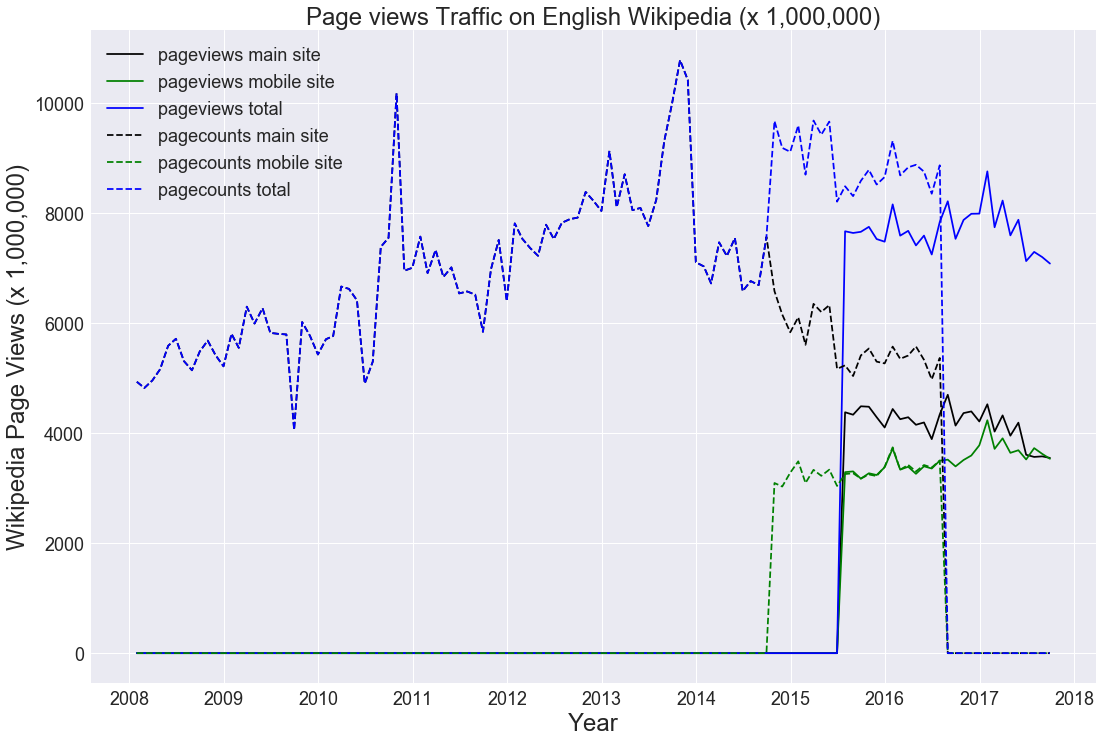

In [35]:
scale = 1000000
x = pd.date_range(start='2008-01', end='2017-10', freq='M')
y_1 = combine["pageview_desktop_views"] / scale
y_2 = combine["pageview_mobile_views"] / scale
y_3 = combine["pageview_all_views"] / scale
y_4 = combine["pagecount_desktop_views"] / scale
y_5 = combine["pagecount_mobile_views"] / scale
y_6 = combine["pagecount_all_views"] / scale

fig = plt.figure(figsize=(18, 12))

# plot pageviews data
plt.plot(x, y_1, label="pageviews main site", color="black")
plt.plot(x, y_2, label="pageviews mobile site", color="green")
plt.plot(x, y_3, label="pageviews total", color="blue")

# plot pagecounts data
plt.plot(x, y_4, linestyle="--", label="pagecounts main site", color="black")
plt.plot(x, y_5, linestyle="--", label="pagecounts mobile site", color="green")
plt.plot(x, y_6, linestyle="--", label="pagecounts total", color="blue")

plt.legend(loc='upper left', prop={'size': 18})
plt.xlabel("Year", fontsize=24)
plt.xticks(fontsize=18)
plt.ylabel("Wikipedia Page Views (x 1,000,000)", fontsize=24)
plt.yticks(fontsize=18)
plt.title("Page views Traffic on English Wikipedia (x 1,000,000)", fontsize=24)

# save the plot
fig.savefig("en-wikipedia_traffic.png")